### Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

### Data Collection

In [2]:
df_train = pd.read_csv(filepath_or_buffer = '/kaggle/input/anadolu-hayat-emeklilik-datathon-coderspace/train.csv',
                       parse_dates        = ['BASLANGIC_TARIHI'],
                       index_col          = 'POLICY_ID')

df_test  = pd.read_csv(filepath_or_buffer = '/kaggle/input/anadolu-hayat-emeklilik-datathon-coderspace/test.csv',
                       parse_dates        = ['BASLANGIC_TARIHI'],
                       index_col          = 'POLICY_ID')

df_subm  = pd.read_csv(filepath_or_buffer = '/kaggle/input/anadolu-hayat-emeklilik-datathon-coderspace/samplesubmission.csv',
                       index_col          = 'POLICY_ID')

### Unnecessary Category Handling

In [3]:
df_train.loc[df_train['SOZLESME_KOKENI_DETAY'] == 'INV_PROC', 'SOZLESME_KOKENI_DETAY'] = 'NEW'
df_train.loc[df_train['SOZLESME_KOKENI'] == 'TRANS', 'SOZLESME_KOKENI'] = 'TRANS_C'

df_test.loc[df_test['SOZLESME_KOKENI_DETAY'] == 'INV_PROC', 'SOZLESME_KOKENI_DETAY'] = 'NEW'
df_test.loc[df_test['SOZLESME_KOKENI'] == 'TRANS', 'SOZLESME_KOKENI'] = 'TRANS_C'

### Fixing Typos

In [4]:
df_train = df_train.rename(columns={'SUBAT_ODENEN_TU': 'SUBAT_ODENEN_TUTAR'})
df_test = df_test.rename(columns={'SUBAT_ODENEN_TU': 'SUBAT_ODENEN_TUTAR'})

In [5]:
typo_check = {
    'GRUPLANMAMI\?': 'GRUPLANMAMIS',
    'B\?REYSEL': 'BIREYSEL',
    '\?GES': 'IGES'
}

df_train['KAPSAM_GRUBU'] = df_train['KAPSAM_GRUBU'].replace(regex=typo_check)
df_test['KAPSAM_GRUBU'] = df_test['KAPSAM_GRUBU'].replace(regex=typo_check)

### Converting Date Type

In [6]:
dates = pd.DatetimeIndex(df_train['BASLANGIC_TARIHI'])

df_train['BASLANGIC_YILI'] = dates.year
df_train['BASLANGIC_AYI'] = dates.month

df_train = df_train.drop(columns=['BASLANGIC_TARIHI'])

In [7]:
dates = pd.DatetimeIndex(df_test['BASLANGIC_TARIHI'])

df_test['BASLANGIC_YILI'] = dates.year
df_test['BASLANGIC_AYI'] = dates.month

df_test = df_test.drop(columns=['BASLANGIC_TARIHI'])

### "GELİR" Column Handling

In [8]:
corrupted = df_train['GELIR'].str.contains(',', na=False)

df_train.loc[corrupted, 'GELIR'] = np.nan
df_train['GELIR'] = df_train['GELIR'].astype(float)

In [9]:
corrupted = df_test['GELIR'].str.contains(',', na=False)

df_test.loc[corrupted, 'GELIR'] = np.nan
df_test['GELIR'] = df_test['GELIR'].astype(float)

### Non-Negative Column Handling

In [10]:
num_cols = ['GELIR', 'COCUK_SAYISI', 'OCAK_ODENEN_TUTAR',
       'OCAK_VADE_TUTARI', 'SUBAT_ODENEN_TUTAR', 'SUBAT_VADE_TUTARI',
       'MART_ODENEN_TUTAR', 'MART_VADE_TUTARI', 'NISAN_ODENEN_TUTAR',
       'NISAN_VADE_TUTARI', 'MAYIS_ODENEN_TUTAR', 'MAYIS_VADE_TUTARI',
       'HAZIRAN_ODENEN_TUTAR', 'HAZIRAN_VADE_TUTARI', 'TEMMUZ_ODENEN_TUTAR',
       'TEMMUZ_VADE_TUTARI', 'AGUSTOS_ODENEN_TUTAR', 'AGUSTOS_VADE_TUTARI',
       'EYLUL_ODENEN_TUTAR', 'EYLUL_VADE_TUTARI', 'EKIM_ODENEN_TUTAR',
       'EKIM_VADE_TUTARI', 'KASIM_ODENEN_TUTAR', 'KASIM_VADE_TUTARI',
       'ARALIK_ODENEN_TUTAR', 'ARALIK_VADE_TUTARI', 'SENE_BASI_HESAP_DEGERI',
       'SENE_SONU_HESAP_DEGERI']

for col in num_cols:
    df_train.loc[df_train[col] < 0, col] = np.nan
    df_test.loc[df_test[col] < 0, col] = np.nan

### Category Decomposition

In [11]:
distinct_cats = ['Kanal1', 'Kanal2', 'Kanal3', 'Kanal4', 'Kanal5', 'Kanal6', 'Kanal7', 'Tele Kanal', 'Online Kanal']
col = 'DAGITIM_KANALI'

df_train[distinct_cats] = False
df_test[distinct_cats] = False

for dcol in distinct_cats:
    df_train.loc[df_train[col].str.contains(dcol, na=False), dcol] = True
    df_test.loc[df_test[col].str.contains(dcol, na=False), dcol] = True
    
df_train = df_train.drop(columns=[col])
df_test = df_test.drop(columns=[col])

In [12]:
distinct_cats = ['GRUPLANMAMIS', 'GRUP', 'STD', 'BIREYSEL', 'GENÇ', 'EV HANIMI', 'KATILIM', 'OKS', 'IGES']
col = 'KAPSAM_GRUBU'

df_train[distinct_cats] = False
df_test[distinct_cats] = False

for dcol in distinct_cats:
    df_train.loc[df_train[col].str.contains(dcol, na=False), dcol] = True
    df_test.loc[df_test[col].str.contains(dcol, na=False), dcol] = True
    
df_train = df_train.drop(columns=[col])
df_test = df_test.drop(columns=[col])

### Exclusive Category Handling

In [13]:
cat_cols = ['OFFICE_ID', 'SIGORTA_TIP', 'SOZLESME_KOKENI', 
            'SOZLESME_KOKENI_DETAY', 'KAPSAM_TIPI', 
            'POLICE_SEHIR', 'CINSIYET', 'UYRUK', 
            'MEMLEKET', 'MESLEK', 'MESLEK_KIRILIM', 'MUSTERI_SEGMENTI', 
            'YATIRIM_KARAKTERI', 'MEDENI_HAL', 'EGITIM_DURUM']

for col in cat_cols:
    df_train.loc[~df_train[col].isin(df_test[col].unique()), col] = 'other'
    df_test.loc[~df_test[col].isin(df_train[col].unique()), col] = 'other'

### Non Frequent Category Handling

In [14]:
df_feat = pd.concat([df_train.drop(['ARTIS_DURUMU'], 1), df_test], axis=0)

In [15]:
threshold = 0.01
cat_cols = ['OFFICE_ID', 'SIGORTA_TIP', 'SOZLESME_KOKENI', 
            'SOZLESME_KOKENI_DETAY', 'KAPSAM_TIPI', 
            'POLICE_SEHIR', 'CINSIYET', 'UYRUK', 
            'MEMLEKET', 'MESLEK', 'MESLEK_KIRILIM', 'MUSTERI_SEGMENTI', 
            'YATIRIM_KARAKTERI', 'MEDENI_HAL', 'EGITIM_DURUM',
            'Kanal1', 'Kanal2', 'Kanal3', 'Kanal4', 'Kanal5', 'Kanal6', 'Kanal7', 'Tele Kanal', 'Online Kanal',
            'GRUPLANMAMIS', 'GRUP', 'STD', 'BIREYSEL', 'GENÇ', 'EV HANIMI', 'KATILIM', 'OKS', 'IGES']

for col in cat_cols:
    mask = df_feat[col].value_counts() < threshold * len(df_feat)
    common_cats = mask[mask].index.unique()

    df_feat.loc[df_feat[col].isin(common_cats), col] = 'other'

### Exploratory Data Analysis

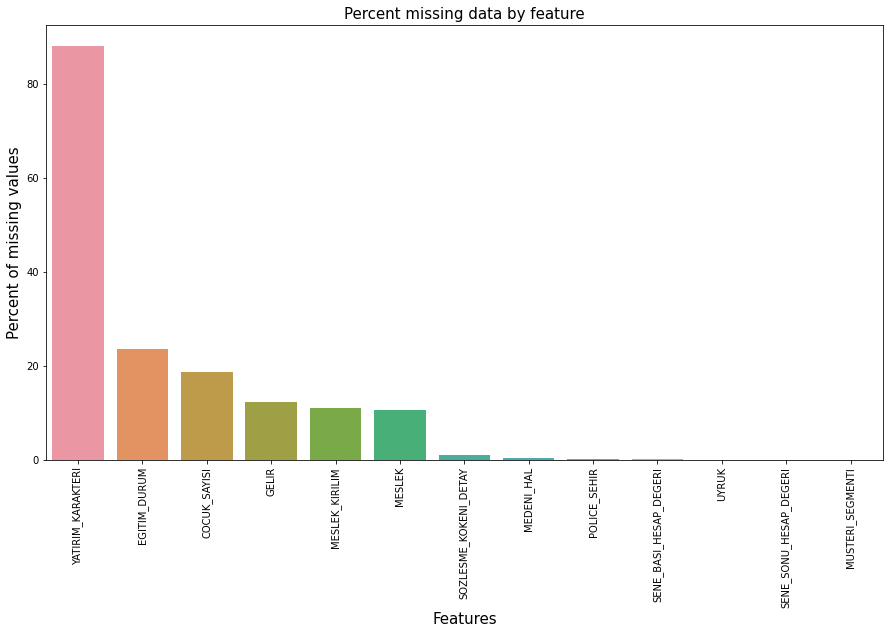

In [16]:
all_data_na = (df_feat.isnull().sum() / len(df_feat)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

fig, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

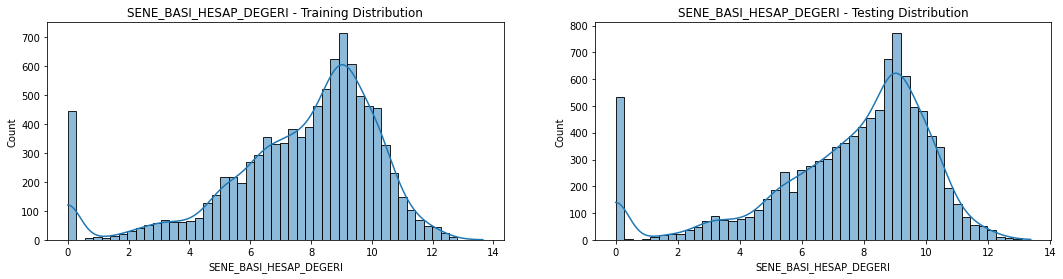

In [17]:
sample_size = 10000
col = 'SENE_BASI_HESAP_DEGERI'

data_1 = df_feat.loc[df_train.index, col].sample(sample_size)
data_2 = df_feat.loc[df_test.index, col].sample(sample_size)

data_1 = np.log(data_1 + 1)
data_2 = np.log(data_2 + 1)

fig, ax = plt.subplots(1, 2, figsize=(18,4))

ax[0].set_title(f'{col} - Training Distribution')
ax[1].set_title(f'{col} - Testing Distribution')

_ = sns.histplot(data=data_1, kde=True, ax=ax[0])
_ = sns.histplot(data=data_2, kde=True, ax=ax[1])

### Category Encoding

In [18]:
cat_cols = ['OFFICE_ID', 'SIGORTA_TIP', 'SOZLESME_KOKENI', 
            'SOZLESME_KOKENI_DETAY', 'KAPSAM_TIPI', 
            'POLICE_SEHIR', 'CINSIYET', 'UYRUK', 
            'MEMLEKET', 'MESLEK', 'MESLEK_KIRILIM', 'MUSTERI_SEGMENTI', 
            'YATIRIM_KARAKTERI', 'MEDENI_HAL', 'EGITIM_DURUM',
            'Kanal1', 'Kanal2', 'Kanal3', 'Kanal4', 'Kanal5', 'Kanal6', 'Kanal7', 'Tele Kanal', 'Online Kanal',
            'GRUPLANMAMIS', 'GRUP', 'STD', 'BIREYSEL', 'GENÇ', 'EV HANIMI', 'KATILIM', 'OKS', 'IGES']

for col in cat_cols:
    df_feat[col] = LabelEncoder().fit_transform(df_feat[col].astype('str'))
    df_feat[col] = df_feat[col].astype('category')

### Feature Engineering

In [19]:
months = ['OCAK', 'SUBAT', 'MART', 'NISAN', 'MAYIS', 'HAZIRAN', 'TEMMUZ', 'AGUSTOS', 'EYLUL', 'EKIM', 'KASIM', 'ARALIK']

df_feat['AYLIK_ODEME_TOP'] = df_feat[[f'{month}_ODENEN_TUTAR' for month in months]].sum(1)
df_feat['AYLIK_VADE_TOP'] = df_feat[[f'{month}_VADE_TUTARI' for month in months]].sum(1)

for month in months:
    df_feat[f'{month}_EKSIK_TUTAR'] = df_feat[f'{month}_ODENEN_TUTAR'] - df_feat[f'{month}_VADE_TUTARI']

In [20]:
df_feat['AYLIK_EKSIK_TUTAR'] = df_feat['AYLIK_ODEME_TOP'] - df_feat['AYLIK_VADE_TOP']

df_feat['VADE_DEGISIM'] = df_feat['ARALIK_VADE_TUTARI'] - df_feat['OCAK_VADE_TUTARI']

df_feat['ODEME_DEGISIM'] = df_feat['ARALIK_ODENEN_TUTAR'] - df_feat['OCAK_ODENEN_TUTAR']

df_feat['HESAP_DEGISIMI'] = df_feat['SENE_SONU_HESAP_DEGERI'] - df_feat['SENE_BASI_HESAP_DEGERI']

### Cross Validation

In [21]:
params = {
    'n_iter': 1000,
    'learning_rate': 0.05,
    'class_weight': {0: 0.2, 1: 0.8},
    'num_leaves': 160,
    'min_child_samples': 200
}

X = df_feat.loc[df_train.index]
y = df_train['ARTIS_DURUMU']

model = lgb.LGBMClassifier(**params)
scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print(f'CV mean: {scores.mean():.4f}')

[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
CV mean: 0.4401


### Prediction

In [22]:
params = {
    'n_iter': 5000,
    'learning_rate': 0.02,
    'class_weight': {0: 0.2, 1: 0.8},
    'num_leaves': 160,
    'min_child_samples': 200
}

X_train = df_feat.loc[df_train.index]
y_train = df_train['ARTIS_DURUMU']
X_test  = df_feat.loc[df_test.index]

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)
df_subm.loc[X_test.index, 'ARTIS_DURUMU'] = model.predict(X_test)

df_subm['ARTIS_DURUMU'] = df_subm['ARTIS_DURUMU'].astype(bool)
df_subm = df_subm.reset_index()
df_subm.head()

[LightGBM] [Warning] num_iterations is set=5000, n_iter=5000 will be ignored. Current value: num_iterations=5000


,POLICY_ID,ARTIS_DURUMU
0,6005558,False
1,1227288,False
2,5694750,False
3,3150098,False
4,4622228,False


In [23]:
df_subm['ARTIS_DURUMU'].value_counts(normalize=True)

False    0.930122
True     0.069878
Name: ARTIS_DURUMU, dtype: float64

In [24]:
df_subm.to_csv('submission.csv', index=False)